# Measuring 5-sigma Depth Curves

In this notebook we will extract an object light curve from the Twinkles field, and measure the 5-sigma limiting depth at each epoch. The reason to do this is to start trying to understand the error properties of the `Monitor` light curves (including their biases) as a function of observation properties, such as image quality and image depth.

### Requirements

You will need the DESC `Monitor` and its dependencies.

You will also need to set up an SSH tunnel to NERSC scidb where the Twinkles PServ data is stored. Follow directions [here](https://github.com/DarkEnergyScienceCollaboration/Monitor/#setting-up-ssh-tunnel-for-database-access) and use the following code from the command line.
```
ssh -L 3307:scidb1.nersc.gov:3306 $USER@cori.nersc.gov
```

In [1]:
import desc.monitor
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/Bryce/lsst/DarwinX86/sims_catalogs/2.3.3.sims/python/lsst/sims/catalogs/db/dbConnection.py:470: UserWarning: Duplicate object type id 25 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/Users/Bryce/lsst/DarwinX86/sims_catalogs/2.3.3.sims/python/lsst/sims/catalogs/db/dbConnection.py:470: UserWarning: Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/Users/Bryce/lsst/DarwinX86/sims_catalogs/2.3.3.sims/python/lsst/sims/catalogs/db/dbConnection.py:470: UserWarning: Duplicate object type id 4 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')


## An Example Object Light Curve

Let's pull out one of the Twinkles objects and visualize it.

In [2]:
dbConn = desc.monitor.dbInterface(database='DESC_Twinkles_Level_2',
                                  #if running from ssh-tunnel uncomment below
                                  host='127.0.0.1', port=3307,
                                  #or if running jupyter-dev uncomment below
                                  #host='scidb1.nersc.gov', port=3306,
                                  driver='mysql')

In [3]:
lc = desc.monitor.LightCurve(dbConn)
lc.build_lightcurve_from_db(objid=48253)

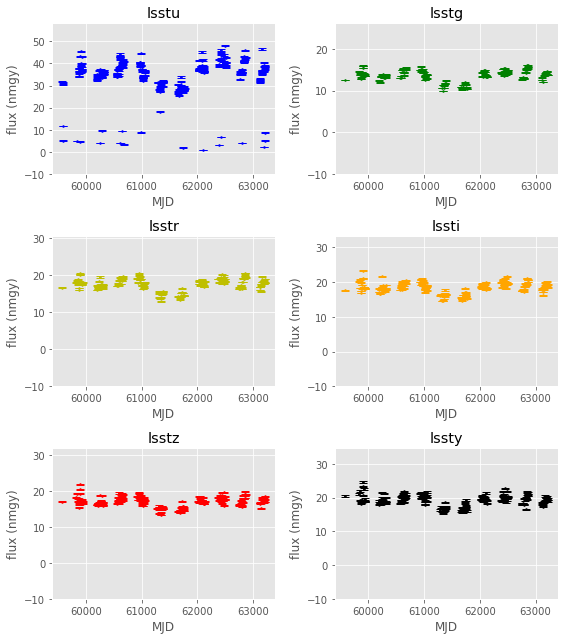

In [4]:
fig = lc.visualize_lightcurve()

## The Matching Depth Curve

Now let's measure the 5-sigma limiting depth (for a point source). We do this by selecting a number of stars from the field, and then for each epoch, querying their flux errors, converting to limiting depth, and then averaging (with sigma-clipping) over the ensemble. All this is done by the `measure_depth_curve()` method.

In [5]:
worker = desc.monitor.Monitor(dbConn)
worker.get_lightcurves([48253])

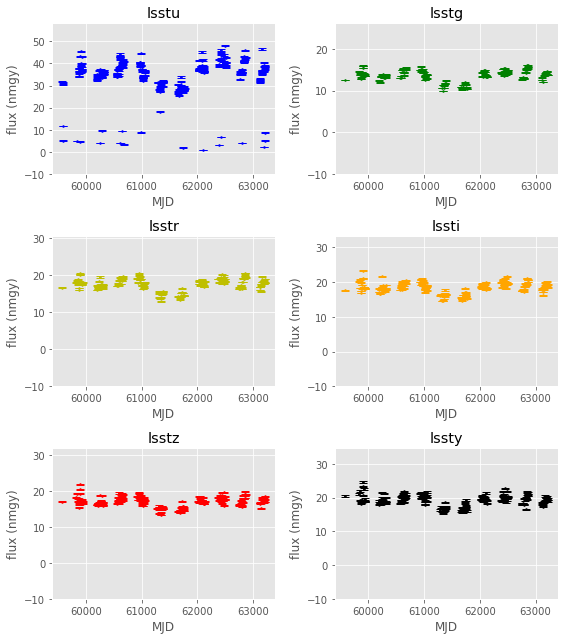

In [6]:
worker.return_lightcurve[48253].visualize_lightcurve(using='flux')
plt.show()

We have three methods for calculating visit depth: `DM`, `DM_modified`, or `stars`. `DM` and `DM_modified` take the `sky_noise` and `seeing` values from the `visit` table in the NERSC database to do the calculations. `stars` uses the flux errors in the stars observed in the Twinkles visits to make the calculation.

In [7]:
dc = worker.measure_depth_curve(using='DM_modified')

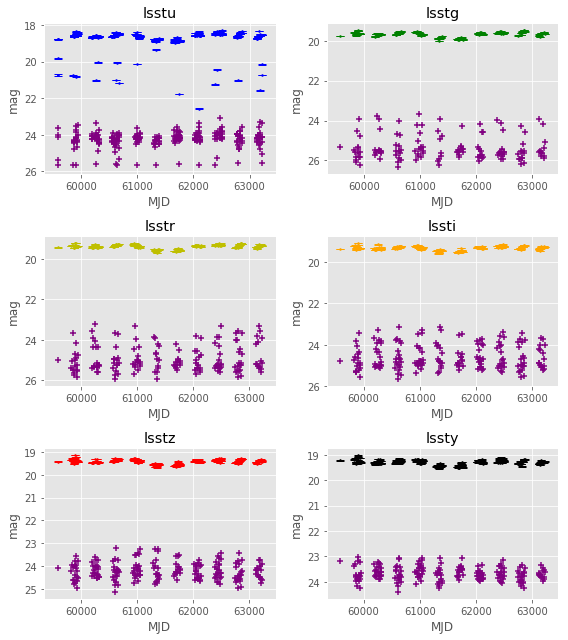

In [8]:
fig = worker.return_lightcurve[48253].visualize_lightcurve(using='mag')
dc.visualize_lightcurve(using='mag', include_errors=False, use_existing_fig=fig)
plt.show()

In [9]:
sc = worker.measure_seeing_curve()

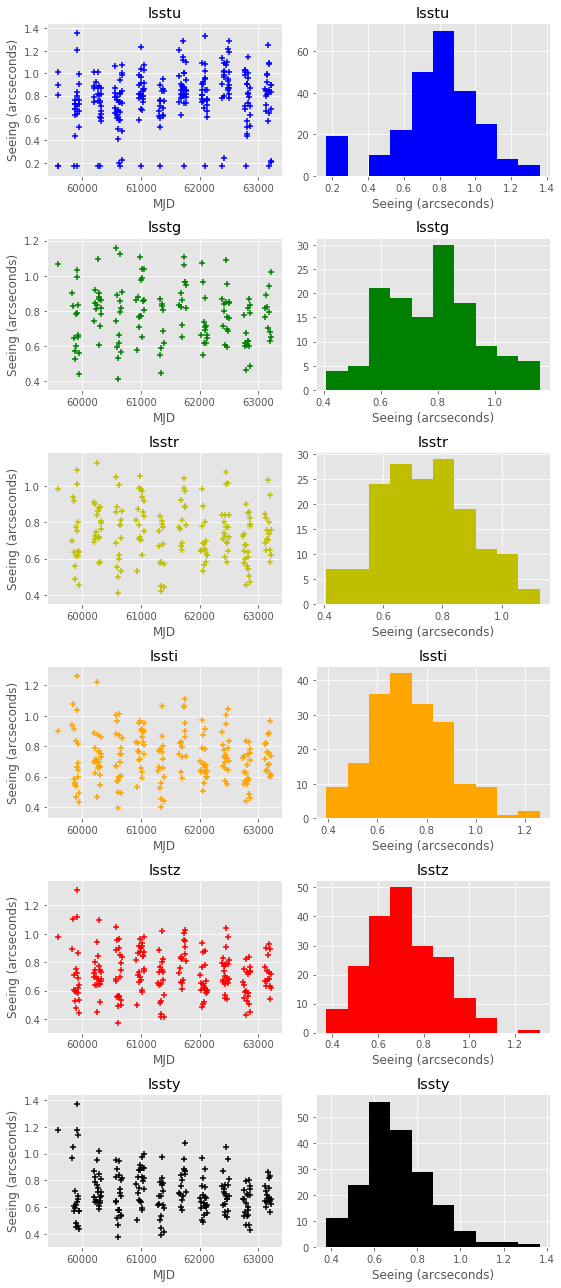

In [10]:
fig = sc.visualize_seeing_curve()
plt.show()

## Conclusion

We show here the monitor's basic lightcurve functionality and its ability to connect to a science database at NERSC to pull out relevant visit information and build lightcurves for objects. This is a valuable tool that makes it easy for anybody to do their own Twinkles analysis.